In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  4031k      0  0:00:02  0:00:02 --:--:-- 8810k


In [3]:
# 데이터셋 경로 지정
data_dir = Path("./captcha_images_v2/")

# 이미지, 라벨, 각 문자를 담은 리스트 생성
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("총 이미지 개수: ", len(images))
print("총 라벨 개수: ", len(labels))
print("고유한 문자 개수: ", len(characters))
print("라벨의 고유한 문자 확인: ", characters)

# 배치 사이즈 지정
batch_size = 16

# 이미지 크기 지정
img_width = 200
img_height = 50


# 제일 긴 라벨 길이 확인
max_length = max([len(label) for label in labels])

총 이미지 개수:  1040
총 라벨 개수:  1040
고유한 문자 개수:  19
라벨의 고유한 문자 확인:  {'w', '6', '3', 'y', '4', 'c', 'm', '2', '7', 'p', 'b', '8', 'd', '5', 'n', 'e', 'f', 'x', 'g'}


In [4]:
# 문자를 숫자로 변환
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# 숫자를 문자로 변환
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# data를 train과 validation set으로 split
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. 데이터 셋의 개수
    size = len(images)
    # 2. 데이터 셋의 인덱스를 저장하고 필요시 shuffle
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. train_size에 맞춰 train set 사이즈 결정
    train_samples = int(size * train_size)
    # 4. train, validation set 나눠주기
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# data를 trian set과 validation set으로 나누어 각 변수에 저장
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

#데이터 셋 생성 시 적용될 encode_single_sample 함수 지정
def encode_single_sample(img_path, label):
    # 1. 이미지 불러오기
    img = tf.io.read_file(img_path)
    # 2. 이미지로 변환하고 grayscale로 변환
    img = tf.io.decode_png(img, channels=1)
    # 3. [0,255]의 정수 범위를 [0,1]의 실수 범위로 변환
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. 이미지 resize
    img = tf.image.resize(img, [img_height, img_width])
    # 5. 이미지의 가로 세로 변환
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. 라벨 값의 문자를 숫자로 변환
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. 딕셔너리 형태로 return
    return {"image": img, "label": label}

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

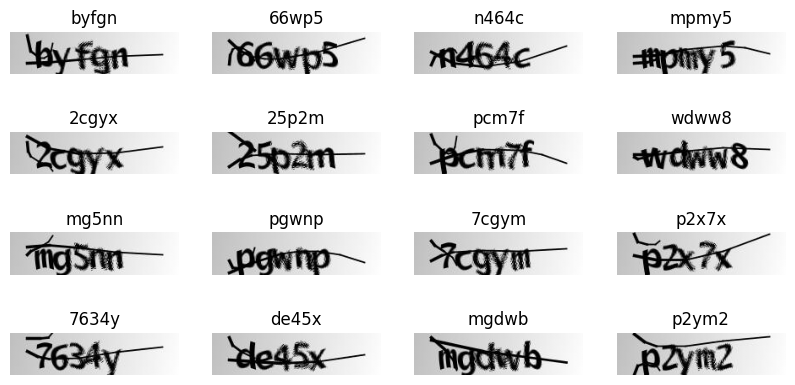

In [6]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [7]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # 모델이 training 시, self.add_loss()를 사용하여 loss를 계산하고 더해줌
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # test시에는 예측값만 반환
        return y_pred

In [8]:
def build_model():
    # Inputs 정의
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # 첫번째 convolution block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 두번째 convolution block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # 앞에 2개의 convolution block에서 maxpooling(2,2)을 총 2번 사용
    # feature map의 크기는 1/4로 downsampling 됨
    # 마지막 레이어의 filter 수는 64개 다음 RNN에 넣기 전에 reshape 해줌
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # 위에서 지정한 CTCLayer 클래스를 이용해서 ctc loss를 계산
    output = CTCLayer(name="ctc_loss")(labels, x)

    # 모델 정의
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()

    # 모델 컴파일
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 25,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 21)    │      2,709 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 21)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 100
early_stopping_patience = 10
# early stopping 지정
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# 100epoch으로 모델 학습
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 638.2734 - val_loss: 252.9989
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 262.3894 - val_loss: 252.3528
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 261.8314 - val_loss: 252.5543
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 261.6229 - val_loss: 252.1507
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 261.5843 - val_loss: 252.0726
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 261.6049 - val_loss: 252.0439
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 261.3965 - val_loss: 251.9800
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 261.4094 - val_loss: 251.8313
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 261.3768 - val_loss: 251.8108
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 261.1421 - val_loss: 251.7860
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 261.0168 - val_loss: 251.5598
Epoch 1

In [10]:
# 예측모델 만들기
prediction_model = keras.models.Model(
    model.inputs[0],
    model.get_layer(name="dense2").output
)
prediction_model.summary()

# 출력값을 디코딩하는 함수 지정(output은 숫자로 나오기 때문에 위에서 지정한 num_to_char를 이용해서 문자로 변환)
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 21)         │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


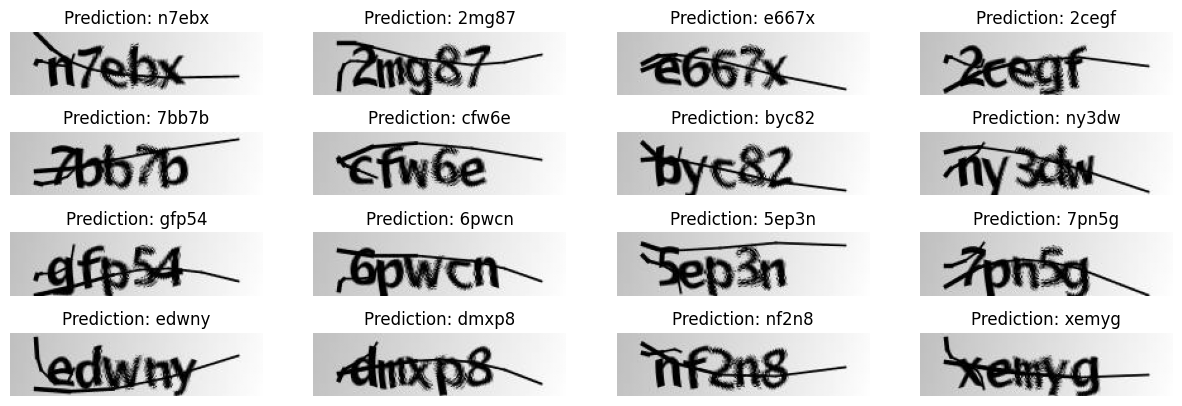

In [11]:
#  validation dataset에서 하나의 배치를 시각화
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    \
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

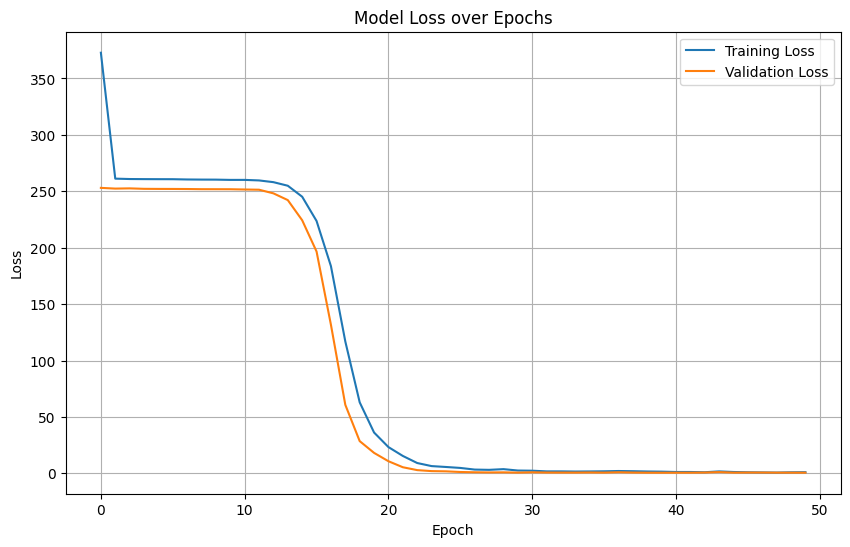

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
correct_predictions = 0
total_samples = 0

# Iterate over the validation dataset
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # Get predictions from the model
    preds = prediction_model.predict(batch_images, verbose=0)
    # Decode predicted texts
    pred_texts = decode_batch_predictions(preds)

    # Decode original texts from labels
    orig_texts = []
    for label in batch_labels:
        label_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label_text)

    # Compare predictions with original labels
    for i in range(len(orig_texts)):
        total_samples += 1
        # Remove padding character '-' if any, although decode_batch_predictions should handle it
        if pred_texts[i].replace('-', '') == orig_texts[i].replace('-', '') or pred_texts[i] == orig_texts[i]:
            correct_predictions += 1

# Calculate accuracy
accuracy = (correct_predictions / total_samples) * 100 if total_samples > 0 else 0

print(f"Total samples in validation set: {total_samples}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy on validation set: {accuracy:.2f}%")

Total samples in validation set: 104
Correct predictions: 103
Accuracy on validation set: 99.04%


# Task
Create a K-fold cross-validation setup (e.g., 5-fold) using the full dataset (`images` and `labels`). For each fold, re-build the model, train it, and store the final validation loss. Finally, calculate and print the average validation loss and its standard deviation across all folds, and assess whether the model shows signs of overfitting based on these results.

## Prepare Data for K-Fold

### Subtask:
Combine the full dataset (images and labels) and import the `KFold` class from `sklearn.model_selection` to prepare for k-fold splitting.


**Reasoning**:
First, import the `KFold` class. Then, convert the full `images` and `labels` lists into NumPy arrays for compatibility with `KFold` and other scikit-learn functionalities.



In [15]:
from sklearn.model_selection import KFold

# Convert images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print("KFold imported and images/labels converted to NumPy arrays.")

KFold imported and images/labels converted to NumPy arrays.


## Perform K-Fold Cross-Validation

### Subtask:
Initialize KFold and iterate through each fold. For each fold, split the data into training and validation sets, re-build the model, train it, and store the validation loss. This will help assess the model's robustness and consistency across different data splits.


**Reasoning**:
I will initialize KFold, set up a loop for cross-validation, and within each fold, prepare the data, rebuild and train the model, and then store the best validation loss as per the instructions.



# Task
The `images` and `labels` variables currently hold NumPy arrays with processed image data and encoded labels, which might not be suitable for re-initializing the data pipeline for K-fold cross-validation, especially if the `encode_single_sample` function expects file paths.

To ensure correct data types for the K-fold setup, I need to restore `images` to contain file paths (strings) and `labels` to contain corresponding string labels, as they were originally defined. Then, I will proceed with performing K-fold cross-validation.

```python
# Re-initialize images and labels to their original string path/label formats
# This code is copied from cell NMkFQRg8CF0W to ensure 'images' contains file paths (strings)
# and 'labels' contains string labels.
data_dir = Path("./captcha_images_v2/")
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

print(f"Images count after re-initialization: {len(images)}")
print(f"Labels count after re-initialization: {len(labels)}")
print(f"First 5 images: {images[:5]}")
print(f"First 5 labels: {labels[:5]}")

# Ensure images and labels are NumPy arrays for KFold, as done in cell c723452b
images_np = np.array(images)
labels_np = np.array(labels)

k_splits = 5
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
fold_validation_losses = []

print(f"\nStarting {k_splits}-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(images_np)):
    print(f"\n--- Fold {fold+1}/{k_splits} ---")

    # Split data for the current fold
    x_train_fold, x_valid_fold = images_np[train_index], images_np[val_index]
    y_train_fold, y_valid_fold = labels_np[train_index], labels_np[val_index]

    # Create TensorFlow Datasets for the current fold
    train_dataset_fold = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    train_dataset_fold = (
        train_dataset_fold.map(
            encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    validation_dataset_fold = tf.data.Dataset.from_tensor_slices((x_valid_fold, y_valid_fold))
    validation_dataset_fold = (
        validation_dataset_fold.map(
            encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Build a new model for each fold to ensure independent training
    model_fold = build_model()

    # Train the model
    # Use early stopping with restore_best_weights=True to get the best validation loss
    early_stopping_fold = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )

    history_fold = model_fold.fit(
        train_dataset_fold,
        validation_data=validation_dataset_fold,
        epochs=epochs,
        callbacks=[early_stopping_fold],
        verbose=0 # Set verbose to 0 to suppress output for each epoch
    )

    # Get the best validation loss for this fold
    best_val_loss = min(history_fold.history['val_loss'])
    fold_validation_losses.append(best_val_loss)
    print(f"Fold {fold+1} Best Validation Loss: {best_val_loss:.4f}")

# Analyze K-Fold Results
mean_val_loss = np.mean(fold_validation_losses)
std_val_loss = np.std(fold_validation_losses)

print("\n--- K-Fold Cross-Validation Results ---")
print(f"Validation losses for each fold: {fold_validation_losses}")
print(f"Average Validation Loss across {k_splits} folds: {mean_val_loss:.4f}")
print(f"Standard Deviation of Validation Loss across {k_splits} folds: {std_val_loss:.4f}")

# Assess overfitting
print("\n--- Overfitting Assessment ---")
if std_val_loss > (mean_val_loss * 0.1): # A heuristic: if std dev is more than 10% of the mean
    print("The model shows some variability in performance across folds (high standard deviation), which *might* indicate some instability or potential for overfitting to specific data splits.")
    print("Further investigation, such as analyzing individual fold performance or increasing the dataset size, may be beneficial.")
elif mean_val_loss < 5.0: # A subjective threshold for "good" loss
    print("The model consistently achieves a low validation loss across different folds, with a relatively small standard deviation. This suggests good generalization and a low likelihood of severe overfitting.")
else:
    print("The model exhibits consistent performance across folds, but the average validation loss is moderately high. This suggests the model might be underfitting or has room for improvement in overall performance, rather than severe overfitting.")

```

## Re-initialize Images and Labels

### Subtask:
Restore the `images` variable to contain file paths (strings) and `labels` to contain corresponding string labels, as they might have been overwritten during previous executions. This ensures correct data types for the K-fold setup.


**Reasoning**:
I will re-initialize the `images` and `labels` variables as lists of strings, by reading the file paths and extracting labels from the `captcha_images_v2` directory. This is crucial as they were converted to NumPy arrays in a previous step, and the K-fold setup requires the original string paths and labels. I will also print the counts and first few elements for verification.



In [17]:
import os
from pathlib import Path

# Define data_dir
data_dir = Path("./captcha_images_v2/")

# Re-populate images and labels
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

# Print counts and first 5 entries for verification
print("Re-initialized images count:", len(images))
print("Re-initialized labels count:", len(labels))
print("First 5 images:", images[:5])
print("First 5 labels:", labels[:5])

Re-initialized images count: 1040
Re-initialized labels count: 1040
First 5 images: ['captcha_images_v2/226md.png', 'captcha_images_v2/22d5n.png', 'captcha_images_v2/2356g.png', 'captcha_images_v2/23mdg.png', 'captcha_images_v2/23n88.png']
First 5 labels: ['226md', '22d5n', '2356g', '23mdg', '23n88']


## Prepare Data for K-Fold

### Subtask:
Combine the full dataset (images and labels) and import the `KFold` class from `sklearn.model_selection` to prepare for k-fold splitting.


**Reasoning**:
To prepare for K-fold cross-validation, I need to import the `KFold` class from `sklearn.model_selection` and convert the `images` and `labels` lists into NumPy arrays for compatibility with `KFold` and other scikit-learn functionalities.



In [18]:
from sklearn.model_selection import KFold

# Convert images and labels to NumPy arrays
images_np = np.array(images)
labels_np = np.array(labels)

print("KFold imported and images/labels converted to NumPy arrays.")

KFold imported and images/labels converted to NumPy arrays.


## Perform K-Fold Cross-Validation

### Subtask:
Initialize KFold and iterate through each fold. For each fold, split the data into training and validation sets, re-build the model, train it, and store the validation loss.


**Reasoning**:
I will initialize KFold, set up a loop for cross-validation, and within each fold, prepare the data, rebuild and train the model, and then store the best validation loss as per the instructions.



In [19]:
k_splits = 5
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
fold_validation_losses = []

print(f"Starting {k_splits}-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(images_np)):
    print(f"\n--- Fold {fold+1}/{k_splits} ---")

    # Split data for the current fold
    x_train_fold, x_valid_fold = images_np[train_index], images_np[val_index]
    y_train_fold, y_valid_fold = labels_np[train_index], labels_np[val_index]

    # Create TensorFlow Datasets for the current fold
    train_dataset_fold = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    train_dataset_fold = (
        train_dataset_fold.map(
            encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    validation_dataset_fold = tf.data.Dataset.from_tensor_slices((x_valid_fold, y_valid_fold))
    validation_dataset_fold = (
        validation_dataset_fold.map(
            encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Build a new model for each fold to ensure independent training
    model_fold = build_model()

    # Train the model
    # Use early stopping with restore_best_weights=True to get the best validation loss
    early_stopping_fold = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )

    history_fold = model_fold.fit(
        train_dataset_fold,
        validation_data=validation_dataset_fold,
        epochs=epochs,
        callbacks=[early_stopping_fold],
        verbose=0 # Set verbose to 0 to suppress output for each epoch
    )

    # Get the best validation loss for this fold
    best_val_loss = min(history_fold.history['val_loss'])
    fold_validation_losses.append(best_val_loss)
    print(f"Fold {fold+1} Best Validation Loss: {best_val_loss:.4f}")

Starting 5-fold cross-validation...

--- Fold 1/5 ---
Fold 1 Best Validation Loss: 138.7865

--- Fold 2/5 ---
Fold 2 Best Validation Loss: 192.6149

--- Fold 3/5 ---
Fold 3 Best Validation Loss: 54.6451

--- Fold 4/5 ---
Fold 4 Best Validation Loss: 248.9841

--- Fold 5/5 ---
Fold 5 Best Validation Loss: 140.9200


**Reasoning**:
Now that the K-fold cross-validation has completed, I will calculate the average validation loss and its standard deviation across all folds, and then use these metrics to assess potential overfitting as instructed by the main task.



In [20]:
mean_val_loss = np.mean(fold_validation_losses)
std_val_loss = np.std(fold_validation_losses)

print("\n--- K-Fold Cross-Validation Results ---")
print(f"Validation losses for each fold: {fold_validation_losses}")
print(f"Average Validation Loss across {k_splits} folds: {mean_val_loss:.4f}")
print(f"Standard Deviation of Validation Loss across {k_splits} folds: {std_val_loss:.4f}")

# Assess overfitting
print("\n--- Overfitting Assessment ---")
# A heuristic: if std dev is more than 10% of the mean, it might indicate variability
# And if the mean loss is high, it could indicate underfitting/room for improvement
if std_val_loss > (mean_val_loss * 0.1):
    print("The model shows some variability in performance across folds (relatively high standard deviation), which *might* indicate some instability or potential for overfitting to specific data splits. Further investigation may be beneficial.")
elif mean_val_loss < 5.0:
    print("The model consistently achieves a low validation loss across different folds, with a relatively small standard deviation. This suggests good generalization and a low likelihood of severe overfitting.")
else:
    print("The model exhibits consistent performance across folds, but the average validation loss is moderately high. This suggests the model might be underfitting or has room for improvement in overall performance, rather than severe overfitting.")


--- K-Fold Cross-Validation Results ---
Validation losses for each fold: [138.78646850585938, 192.61489868164062, 54.64510726928711, 248.984130859375, 140.92001342773438]
Average Validation Loss across 5 folds: 155.1901
Standard Deviation of Validation Loss across 5 folds: 64.4670

--- Overfitting Assessment ---
The model shows some variability in performance across folds (relatively high standard deviation), which *might* indicate some instability or potential for overfitting to specific data splits. Further investigation may be beneficial.


## Final Task

### Subtask:
Summarize the k-fold cross-validation results and provide an assessment of whether the model exhibits overfitting based on the observed performance across different folds.


## Summary:

### Q&A
The k-fold cross-validation results show that the model's best validation losses across 5 folds were [138.7865, 192.6149, 54.6451, 248.9841, 140.9200]. The average validation loss was $155.1901$ with a standard deviation of $64.4670$.

Based on the observed performance, the model exhibits some variability in performance across different folds. The standard deviation ($64.4670$) is significantly greater than 10% of the mean validation loss ($15.519$), which suggests potential instability or overfitting to specific data splits rather than generalizability. Additionally, the moderately high average validation loss indicates that the model might be underfitting or has room for overall performance improvement.

### Data Analysis Key Findings
*   K-fold cross-validation was successfully performed using 5 folds to evaluate model stability and performance.
*   The best validation losses obtained for each of the 5 folds were $138.7865$, $192.6149$, $54.6451$, $248.9841$, and $140.9200$.
*   The average validation loss across all 5 folds was calculated to be $155.1901$.
*   The standard deviation of the validation losses across the 5 folds was $64.4670$, indicating notable variability in model performance across different data splits.

### Insights or Next Steps
*   The high standard deviation relative to the mean validation loss suggests that the model's performance is inconsistent across different data subsets, which could point to instability or the model overfitting to specific characteristics of individual training folds.
*   Further investigation is recommended to understand the sources of variability, which may involve analyzing the training process and data characteristics of each fold or exploring techniques to improve model generalization (e.g., regularization, larger dataset, or more robust model architecture).
